<a href="https://colab.research.google.com/github/shaoern1/SITNVIDIA/blob/main/EDA_on_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [18]:
# Opening of json file + reading

jsonpath = "/content/combined_data.json"

with open(jsonpath, "r") as f:
  combined_data = json.load(f)

In [19]:
# Normalise json and print head
df = pd.json_normalize(combined_data, 'questions_and_answers', ['video_id','video_path', 'duration'])
print(df.head())

                                            question  \
0      Can you give me a brief summary of the video?   
1  Can you describe the video in detail based on ...   
2     Are the babies with their mother in the video?   
3          What are the children doing in the video?   
4             What are the main events in the video?   

                                              answer       video_id  \
0  Sure! The video depicts two children in a bath...  v_AWAMhmc08Cw   
1  In the video, two children can be seen sitting...  v_AWAMhmc08Cw   
2  Yes, the video shows the babies with their mot...  v_AWAMhmc08Cw   
3  The video shows two children sitting in a bath...  v_AWAMhmc08Cw   
4  The video mainly shows two children playing in...  v_AWAMhmc08Cw   

                                    video_path duration  
0  ../tar_train/tar_output/./v_AWAMhmc08Cw.mp4   140.81  
1  ../tar_train/tar_output/./v_AWAMhmc08Cw.mp4   140.81  
2  ../tar_train/tar_output/./v_AWAMhmc08Cw.mp4   140.81  
3  .

In [20]:
# Count the number of unique video IDs
num_unique_videos = df['video_id'].nunique()
print(f"Number of unique videos: {num_unique_videos}")

# Count the number of rows in the DataFrame
num_rows = df.shape[0]
print(f"Number of rows: {num_rows}")
# Check for any null columns
print(df.isnull().sum())

Number of unique videos: 411
Number of rows: 3109
question       0
answer         0
video_id       0
video_path     0
duration      14
dtype: int64


In [21]:
# Created group df by video_id

# Group by video_id and aggregate questions and answers
grouped_df = df.groupby('video_id').agg({
    'question': lambda x: list(x),
    'answer': lambda x: list(x),
    'video_path': 'first',
    'duration': 'first'
}).reset_index()
print("Grouped DataFrame:")
print(grouped_df.head())



Grouped DataFrame:
        video_id                                           question  \
0  v_--veKG73Di4  [Could you provide a brief summary of the vide...   
1  v_-8awLlFLcQc  [What task is the man performing in the video?...   
2  v_-FWGLSfI13Q  [Could you describe the video content in brief...   
3  v_-GRvxWH4axc  [What does the little girl do in the video?, C...   
4  v_-Jp86pFKlsw  [What is the main activity going on in the vid...   

                                              answer  \
0  [Sure. The video is about a man and a woman wh...   
1  [The man is cleaning an office by vacuuming th...   
2  [Sure. The video shows a family carving out an...   
3  [In the video, the little girl dressed in a fl...   
4  [The main activity in the video involves a wom...   

                                    video_path duration  
0  ../tar_train/tar_output/./v_--veKG73Di4.mp4   115.36  
1  ../tar_train/tar_output/./v_-8awLlFLcQc.mp4   161.03  
2  ../tar_train/tar_output/./v_-FWGLSfI13Q.

In [22]:
# Filter the DataFrame to show rows where 'duration' is null
null_duration_rows = grouped_df[grouped_df['duration'].isnull()]

# Get the number of rows with null duration
num_rows = null_duration_rows.shape[0]
print(f"Number of rows with null duration: {num_rows}")

# Print unique video_id values from these rows
if num_rows > 0:  # Check if there are any rows with null duration
    unique_video_ids = null_duration_rows['video_id'].unique()
    print("Unique video IDs with null duration:", unique_video_ids)
else:
    print("No rows with null duration.")


Number of rows with null duration: 2
Unique video IDs with null duration: ['v_XH-YlSbgxkY' 'v_vgXU0u-rN9c']


In [23]:
# Rows without durations shows that they contain video files with broken .mp4 (will research more)
# For now I will drop the columns (28, should be 3068 left)

num_rows = grouped_df.shape[0]
print(f"Number of rows: {num_rows} (411)")

# Drop rows where 'duration' is NaN in place
grouped_df.dropna(subset=['duration'], inplace=True)

# Now check the number of rows left in the DataFrame
num_rows = grouped_df.shape[0]
print(f"Number of rows after dropping: {num_rows} (411-2=409)")


Number of rows: 411 (411)
Number of rows after dropping: 409 (411-2=409)


In [24]:
# Check for duplicates in the grouped DataFrame
duplicate_video_ids = grouped_df[grouped_df.duplicated(subset='video_id', keep=False)]
num_duplicates = duplicate_video_ids['video_id'].nunique()
print(f"Number of duplicate video IDs after grouping: {num_duplicates}")
if not duplicate_video_ids.empty:
    print("Duplicate video ID rows after grouping:")
    print(duplicate_video_ids)

Number of duplicate video IDs after grouping: 0


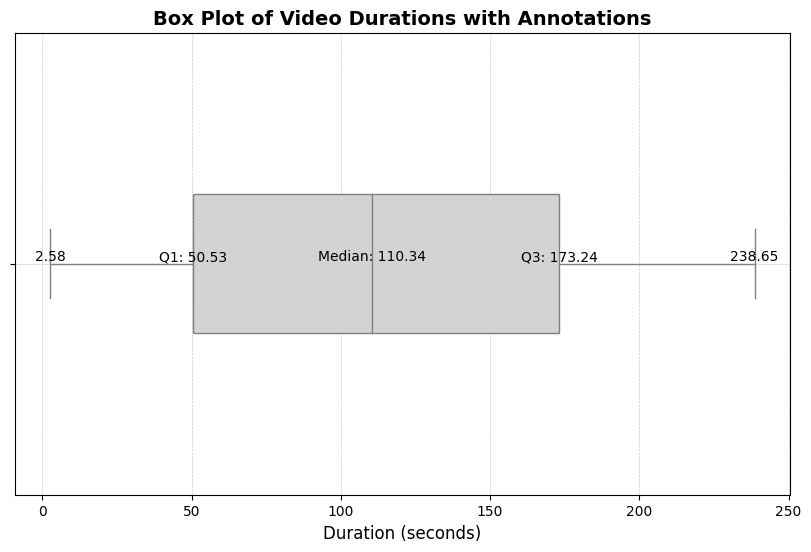

In [25]:
# Calculate quartiles and IQR for manual outlier detection
Q1 = grouped_df['duration'].quantile(0.25)
Q3 = grouped_df['duration'].quantile(0.75)
median = grouped_df['duration'].median()
IQR = Q3 - Q1
lower_whisker = grouped_df['duration'][grouped_df['duration'] >= Q1 - 1.5 * IQR].min()
upper_whisker = grouped_df['duration'][grouped_df['duration'] <= Q3 + 1.5 * IQR].max()

# Create a box plot for video durations
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x=grouped_df['duration'], color='lightgray', width=0.3)

# Annotate quartiles and whiskers
plt.text(x=lower_whisker, y=0, s=f'{lower_whisker:.2f}', verticalalignment='bottom', horizontalalignment='center', color='black', fontsize=10)
plt.text(x=upper_whisker, y=0, s=f'{upper_whisker:.2f}', verticalalignment='bottom', horizontalalignment='center', color='black', fontsize=10)
plt.text(x=Q1, y=0, s=f'Q1: {Q1:.2f}', verticalalignment='bottom', horizontalalignment='center', color='black', fontsize=10)
plt.text(x=Q3, y=0, s=f'Q3: {Q3:.2f}', verticalalignment='bottom', horizontalalignment='center', color='black', fontsize=10)
plt.text(x=median, y=0, s=f'Median: {median:.2f}', verticalalignment='bottom', horizontalalignment='center', color='black', fontsize=10)

# Label and show the plot
plt.title('Box Plot of Video Durations with Annotations', fontsize=14, fontweight='bold')
plt.xlabel('Duration (seconds)', fontsize=12)
plt.xticks(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Show plot
plt.show()


count    409.000000
mean       7.567237
std        1.809832
min        6.000000
25%        7.000000
50%        7.000000
75%        7.000000
max       16.000000
Name: question, dtype: float64


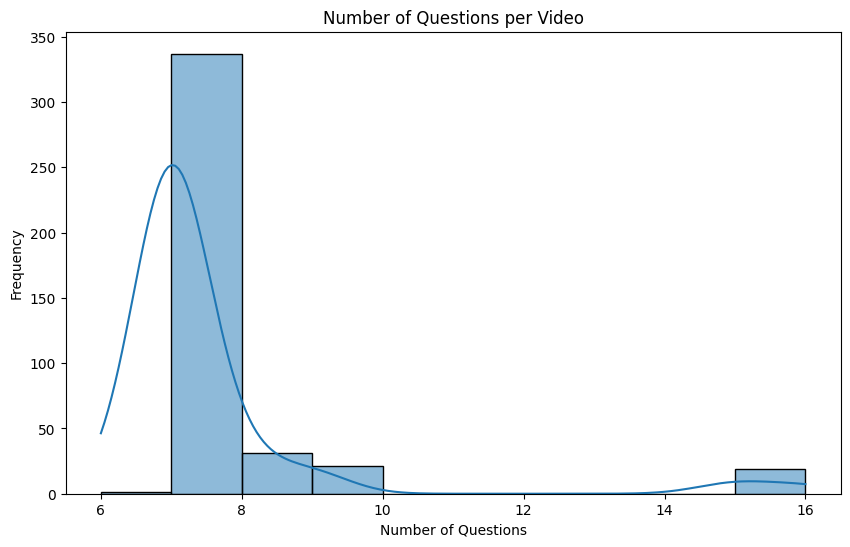

In [26]:
# number of questions & answers per question
questions_per_video = grouped_df['question'].apply(len)
print(questions_per_video.describe())

# Plot the number of questions per video
plt.figure(figsize=(10, 6))
sns.histplot(questions_per_video, kde=True)
plt.title('Number of Questions per Video')
plt.xlabel('Number of Questions')
plt.ylabel('Frequency')
plt.show()


In [27]:
# Calculate the number of questions for each video
grouped_df['num_questions'] = grouped_df['question'].apply(len)

# Identify the video ID with the maximum number of questions
max_questions_video = grouped_df.loc[grouped_df['num_questions'].idxmax()]
print(f"Video ID with the maximum number of questions: {max_questions_video['video_id']}")
print(f"Number of questions: {max_questions_video['num_questions']}")
print(f"Questions: {max_questions_video['question']}")

# Its is true that this video has 17 Q&A

Video ID with the maximum number of questions: v_--veKG73Di4
Number of questions: 16
Questions: ['Could you provide a brief summary of the video?', 'Can you create a story inspired by the man playing the bongos and the woman dancing in the video?', 'How does the performance conclude?', 'Can you describe the content of the video?', 'Can you describe the events that took place in the video?', 'Can you describe the video in detail?', 'Can you describe the video content in detail?', 'Could you describe the performance in the video?', 'Can you describe the clothing worn by the performers in the video?', 'Who takes the water bottle from the woman, and what happens after that?', 'What happens when the woman is dancing and a man on a bike passes by the scene?', 'What is the video about?', 'Can you provide a detailed description of the video content?', 'What are the main events that occur in the video?', 'Can you describe what is happening in the video?', 'Could you summarize the main points of